In [1]:
import json, warnings, gc, math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy.interpolate import CubicSpline
import gc

%matplotlib inline

## Benetech: 5 Chart Types Generator

The following notebook provides a way to generate additional data for the [Benetech - Making Graphs Accessible Competition](https://www.kaggle.com/competitions/benetech-making-graphs-accessible). If you have any suggestions to improve the notebook, please let me know.

## Usage

Dodify the `GENERATE_N_IMAGES` variable to determine how many charts to create. Each chart is saved in the format `NUMBER.jpg`, where `NUMBER` is the count of the charts up to that point.

If you set `ALL_TYPES` to true, then 5x `GENERATE_N_IMAGES` will be generated. This variable is used to showcase all the chart types, but should be set to False when generating a large dataset for training.

The metadata is stored in CSV format similar to [Google's DePlot Model](https://huggingface.co/google/deplot). Something like this. 

`2005 | 4344.2 <0x0A> 2006 | 4549.7 <0x0A> 2007 | 4667.2 <0x0A> 2008 | 4579.1 <0x0A> 2009 | 4579.1 <0x0A> 2010 | 4520.4 <0x0A> 2011 | 4373.5 <0x0A> 2012 | 4079.9 <0x0A> 2013 | 3844.9 <0x0A> 2014 | 3492.6 <0x0A> 2015 | 3610.0 <0x0A> 2016 | 3991.8 <0x0A> 2017 | 4314.8 <0x0A> 2018 | 3962.4 <0x0A> 2019 | 4256.1`

## 500K Generated Charts

I pre-generated 100k charts of each type, and have uploaded them as a dataset [here](https://www.kaggle.com/datasets/brendanartley/benetech-extra-generated-data).

## Version Notes

V7: Added Horizontal Bar Graphs, Metadata format change, Capitalization, Random colours, Increased categorical label variation (ie. "10-20", "100-1000")

V8: Added all bar plots, more styles, fixed metadata, overlapping labels, and other various bugs fixes/features.

NOTE: Generation is limited to 5k-6k imgs (due to a matplotlib memory leak error). If you run this code in a .py script outside of the kaggle environment then this memory leak does not occur. Just uncomment the last 3 line of the plot_vert_bar() function when running locally. Also thanks to [@Huiqin](https://www.kaggle.com/qinhui1999) for sharing a possible solution [here](https://www.kaggle.com/code/brendanartley/benetech-5-chart-types-generator/comments#2256026). The memory leak still occurs in the Kaggle environment, but it could be a solution for a local jupyter environment?

In [2]:
GENERATE_N_IMAGES = 50000
VISUALIZE_FIRST_N = 10
SEED = 77
ALL_TYPES = True

# Pick chart_type (if ALL_TYPES is TRUE, all charts are generated)
ALL_TYPES = False
chart_types = 's' # each bar type is represented by a letter.
chart_type = chart_types[0]

Here is a sample image given by the organizers. I will try and generate somewhat similar charts.

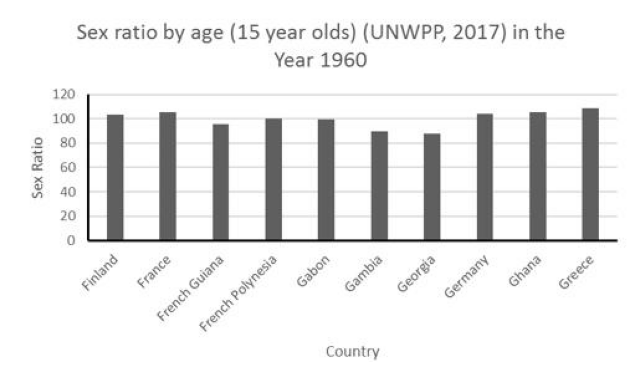

In [3]:
# Display the image
fig = plt.figure(figsize=(8, 8))
img = Image.open("/Users/nakagawaayato/compe/kaggle/mga/original_data/train/images/e9ee3fc0c1de.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

## GLOVE

Loading glove embeddings to sample similar words from embedding space. We use glove to increase the size of our vocabulary for the generation of graph titles, and axis titles.

I also create a helper function to help filter out difficult characters that are unlikely to be in the graphs.

In [4]:
%%time

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

kvs = KeyedVectors.load_word2vec_format('/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/glove/glove.6B.50d.txt', binary=False, no_header=True)

CPU times: user 5.85 s, sys: 215 ms, total: 6.07 s
Wall time: 6.77 s


In [5]:
def remove_non_ascii_strings(strings):
    """
    Remove any non-ASCII strings from a list of strings.
    """
    ascii_strings = []
    for string in strings:
        is_ascii = all(ord(c) < 128 for c in string)
        if is_ascii:
            ascii_strings.append(string)
    return ascii_strings

## Variables for Axis Titles

Most axis titles and plot titles contain some sort of numerical measure. We make sure to include one of these terms in each title.

The next cell uses a hardcoded list of numerical terms, and we expand our vocabulary using GLOVE.

In [6]:
# -- Random Numerical Terms --
numericals = ['p/e ratio', 'mileage', 'electricity consumption', 'rental rate', 'inflation rate', 'electricity consumption per capita', 'height', 'interest rate', 'pesticide residue level', 'risk score', 'ocean acidification index', 'aquifer depletion rate', 'crime rate', 'endocrine disruptors', 'wetland health index', 'vitamin a content', 'coral reef health index', 'total assets', 'cholesterol content', 'fertility rate', 'global warming potential', 'density', 'minimum wage', 'school enrollment', 'mercury emissions', 'amino acid score', 'fiber length', 'coastal habitat quality', 'total antioxidant capacity', 'ozone depletion potential', 'melting point', 'water quality index', 'weight', 'water stress', 'hunger rate', 'water activity', 'total debt', 'infestation level', 'threatened species protection', 'material footprint', 'sodium content', 'grain size', 'nuclear waste generation', 'birthrate', 'quality score', 'freshwater scarcity index', 'rating', 'greenhouse gas emissions', 'acid deposition', 'pectin content', 'mold count', 'water consumption', 'antibiotic use in livestock', 'polyphenol content', 'land degradation', 'salinity level', 'obesity rate', 'soil erosion', 'water content', 'value', 'urban sprawl', 'ph level', 'tannin content', 'lot size', 'trade balance', 'nitrate content', 'mental health score', 'rainfall', 'land use change', 'carbon emissions', 'area', 'biochemical oxygen demand', 'sales', 'food waste generation', 'gross energy value', 'sulfite content', 'texture profile analysis', 'credit score', 'utility cost', 'circumference', 'wetland coverage', 'gdp', 'renewable water resources', 'water holding capacity', 'length', 'job satisfaction', 'marine protected areas coverage', 'brix value', 'digestibility score', 'fatty acid profile', 'ochratoxin a level', 'water efficiency', 'market share', 'vitamin c content', 'water scarcity', 'investment', 'gross profit', 'marine ecosystem health index', 'savings', 'budget', 'protected area coverage', 'yield strength', 'sulfur dioxide emissions', 'toxic chemicals management', 'serving size', 'oxygen demand index', 'flood risk', 'seed count', 'wastewater treatment', 'food safety index', 'phytic acid content', 'saturated fat content', 'free fatty acid content', 'debt', 'natural disaster risk', 'plastic waste generation', 'life expectancy', 'microplastic pollution', 'stock price', 'roi', 'caloric density', 'balance', 'air pollution', 'sustainable fisheries', 'vitality score', 'water availability', 'dietary fiber content', 'glycemic index', 'defect count', 'iodine value', 'longitude', 'toxicity index', 'residual sugar level', 'flour protein content', 'inventory', 'operating expenses', 'renewable energy consumption', 'oil content', 'cocoa percentage', 'stormwater management', 'soluble fiber content', 'carbohydrate content', 'calories', 'environmental governance index', 'fiscal year', 'relative humidity', 'electric current', 'phosphorus content', 'fat content', 'co2 emissions per capita', 'wildfires', 'grit size', 'energy density', 'units sold', 'biodiversity index', 'ecological footprint', 'fish stocks', 'yeast and mold count', 'heavy metal contamination', 'drought index', 'wind energy production', 'particulate matter emissions', 'species richness', 'loan', 'usage', 'pesticide regulation stringency', 'vitamin d content', 'lactic acid bacteria count', 'total solids content', 'national parks coverage', 'temperature', 'total fat content', 'social security', 'body mass index', 'benthic habitat quality', 'groundwater depletion rate', 'habitat fragmentation', 'clean energy production', 'air quality index', 'enrollment rate', 'land area', 'transparency of environmental reporting', 'duration', 'total phenolic content', 'employment rate', 'iron content', 'radioactive pollution', 'hydrogenation level', 'working capital', 'population', 'heart rate', 'humidity level', 'cognitive ability', 'potassium content', 'protein content', 'whey protein content', 'tax rate', 'gel strength', 'curing time', 'preservative level', 'solid waste generation', 'heavy metal pollution index', 'nitrogen oxide emissions', 'sugar content', 'dissolved oxygen concentration', 'per capita waste generation', 'starch content', 'distance', 'immigration rate', 'trans fat content', 'water consumption per capita', 'insoluble fiber content', 'moisture content', 'river health index', 'expenses', 'sea level rise', 'wheat gluten content', 'depression score', 'earnings', 'sensory acceptability score', 'recycling rate', 'patient satisfaction', 'methane emissions', 'carbon dioxide concentration', 'unemployment rate', 'dry matter content', 'hazardous waste generation', 'organic chemical pollution', 'cash flow', 'hourly wage', 'nutrient density', 'genetic variation', 'yearly income', 'water use efficiency', 'salary', 'thawing time', 'climate change vulnerability', 'global temperature', 'soil health index', 'water pollution index', 'volatile organic compound emissions', 'energy efficiency', 'sustainable agriculture policy stringency', 'profit margin', 'phosphorus balance', 'chemical pollution index', 'dividend', 'forest cover', 'property value', 'macronutrient ratio', 'lipid oxidation', 'particulate matter concentration', 'net income', 'water solubility index', 'blood pressure', 'terrestrial protected areas coverage', 'revenue', 'ecosystem services value', 'time', 'wind speed', 'urban heat island intensity', 'pesticide use', 'thermal conductivity', 'age', 'oxidation stability', 'body temperature']
measurements = ["centimeters","liters","grams","kilometers per hour","pounds","feet","ounces","miles per hour","inches","celsius","fahrenheit","millimeters","meters","yards","square meters","square feet","square miles","square inches","square centimeters","square millimeters","cubic meters","cubic feet","cubic inches","gallons","quarts","pints","fluid ounces","cups","teaspoons","tablespoons","miles","milligrams","kilograms","tons","ounces per square inch","pounds per square inch","newtons","dynes","pascals","kilopascals","megapascals","psi","degrees","radians","revolutions per minute","hertz","watts","kilowatts","megawatts","horsepower","joules","calories","kilocalories","electron volts","ampere","milliampere","volt","millivolt","ohm","milliohm","henry","millihenry","farad","picofarad","nanofarad","microfarad","weber","tesla","gauss","lux","lumens","candela","decibels","hertz","kilohertz","megahertz","gigahertz","terahertz","bits","bytes","kilobits","megabits","gigabits","terabits","kilobytes","megabytes","gigabytes","terabytes","pixels","dots per inch","lines per inch","frames per second","pages","items","minutes","hours","days","weeks","months","years","USD","EUR","GBP","JPY","AUD","CAD","CHF","CNY","HKD","INR","KRW","MXN","MYR","NZD","PHP","SGD","THB","TWD","BTC","ETH","XRP"]
numericals = list(set(numericals + measurements))

def get_more_words(arr, kvs):
    """
    Function to sample similar words from GLOVE embeddings.
    """
    new_words = set(arr)
    print("word_size: ", len(new_words))
    for i, word in tqdm(enumerate(arr), total=len(arr)):
        if word.count(" ") != 0:
            continue
        try:
            sim = kvs.most_similar(word, topn=20)
        except:
            continue
        for k, v in sim:
            if k not in new_words:
                if k.isalpha() and all(ord(c) < 128 for c in k):
                    new_words.add(k)
    print("final_size: ", len(new_words))
    return list(new_words)

numericals = get_more_words(numericals, kvs)

word_size:  385


100%|██████████| 385/385 [00:01<00:00, 270.47it/s]

final_size:  1572


## Variables for Categorical Data Series

Getting various words that can be used as categorical data series.

First we have some geographical words (states, countries, continents, subcontinents) that all make sense to be grouped together.

In [7]:
# -- States/Counties---
states = pd.read_csv("/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/us-state-county-name-codes/states.csv")
counties = pd.read_csv("/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/us-state-county-name-codes/US Countiess.csv")

countries = ["Afghanistan","Albania","Algeria","Andorra","Angola","Antigua & Deps","Argentina","Armenia","Australia","Austria","Azerbaijan","Bahamas","Bahrain","Bangladesh","Barbados","Belarus","Belgium","Belize","Benin","Bhutan","Bolivia","Bosnia Herzegovina","Botswana","Brunei","Bulgaria","Burkina","Burundi","Cambodia","Cameroon","Canada","Cape Verde","Central African Rep","Chad","Chile","China","Colombia","Comoros","Congo","Congo","Costa Rica","Croatia","Cuba","Cyprus","Czech Republic","Denmark","Djibouti","Dominica","Dominican Republic","East Timor","Ecuador","Egypt","El Salvador","Equatorial Guinea","Eritrea","Estonia","Ethiopia","Fiji","Finland","France","Gabon","Gambia","Georgia","Germany","Ghana","Greece","Grenada","Guatemala","Guinea","Guinea-Bissau","Guyana","Haiti","Honduras","Hungary","Iceland","India","Indonesia","Iran","Iraq","Ireland","Israel","Italy","Ivory Coast","Jamaica","Japan","Jordan","Kazakhstan","Kenya","Kiribati","Korea North","Korea South","Kosovo","Kuwait","Kyrgyzstan","Laos","Latvia","Lebanon","Lesotho","Liberia","Libya","Liechtenstein","Lithuania","Luxembourg","Macedonia","Madagascar","Malawi","Malaysia","Maldives","Mali","Malta","Marshall Islands","Mauritania","Mauritius","Mexico","Micronesia","Moldova","Monaco","Mongolia","Montenegro","Morocco","Mozambique","Myanmar", "Burma", "Namibia","Nauru","Nepal","Netherlands","New Zealand","Nicaragua","Niger","Nigeria","Norway","Oman","Pakistan","Palau","Panama","Papua New Guinea","Paraguay","Peru","Philippines","Poland","Portugal","Qatar","Romania","Russian Federation","Rwanda","St Kitts & Nevis","St Lucia","Saint Vincent & the Grenadines","Samoa","San Marino","Sao Tome & Principe","Saudi Arabia","Senegal","Serbia","Seychelles","Sierra Leone","Singapore","Slovakia","Slovenia","Solomon Islands","Somalia","South Africa","South Sudan","Spain","Sri Lanka","Sudan","Suriname","Swaziland","Sweden","Switzerland","Syria","Taiwan","Tajikistan","Tanzania","Thailand","Togo","Tonga","Trinidad & Tobago","Tunisia","Turkey","Turkmenistan","Tuvalu","Uganda","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay","Uzbekistan","Vanuatu","Vatican City","Venezuela","Vietnam","Yemen","Zambia","Zimbabwe"]
regions = ["Africa","Central Africa","Eastern Africa","Northern Africa","Southern Africa","Western Africa","Asia","Central Asia","Eastern Asia","Northern Asia","South-Eastern Asia","Southern Asia","Western Asia","Europe","Eastern Europe","Northern Europe","Southern Europe","Western Europe","North America","Central America","Caribbean","Northern America","South America","Oceania","Australia and New Zealand","Melanesia","Micronesia","Polynesia"]
counties = counties["X4"].str.split().str[0].drop_duplicates().to_list() # extracted 1st word
states_abb = states["Abbreviation"].to_list()
states = states["State"].to_list()
places = list(set(countries + regions + states + counties + states_abb))

# Remove non ASCII Characters, and set to lowercase
places = remove_non_ascii_strings(places)
places = [x.lower() for x in places]
del countries, regions, counties, states

print("len: ", len(places))

len:  2123


Next, we have some random nouns. We use [GLOVE](https://nlp.stanford.edu/pubs/glove.pdf) to get similar words to these nouns, and create a word map to sample from. Although far from perfect, this will give us a large corpora to sample from for the categoical data series.

I precompute these terms and provide them as a dictionary. Computing these from scratch takes ~10mins.

In [8]:
# # -- Random Nouns --
# nouns = pd.read_csv("/kaggle/input/list-of-nouns/nounlist.csv")["ATM"].drop_duplicates().to_list()
# nouns = [x.split()[0].lower() for x in nouns]
# nouns += ['bicycle', 'notebook', 'sunglasses', 'lawnmower', 'headphones', 'coffee', 'wristwatch', 'backpack', 'shower', 'chandelier', 'barbecue', 'water', 'couch', 'chess', 'toothbrush', 'piano', 'baseball', 'suitcase', 'lamp', 'soccer', 'screwdriver', 'umbrella', 'candle', 'teddy', 'flashlight', 'fireplace', 'iron', 'tennis', 'plunger', 'potato', 'paper', 'surfboard', 'tire', 'teapot', 'hair', 'guitar', 'book', 'basketball', 'whistle', 'broom', 'bowling', 'oven', 'spoon', 'camera', 'shampoo', 'dumbbell', 'speaker', 'hand', 'purse', 'dog', 'calculator', 'salt', 'luggage', 'toaster', 'radio', 'blender', 'kite', 'swimming', 'mouse', 'car', 'nail', 'ping', 'chair', 'highlighter', 'laptop', 'hiking', 'towel', 'frying', 'wine', 'tape', 'drill', 'ski', 'pen', 'rubber', 'suitcase', 'television', 'globe', 'pillow', 'watering', 'skateboard', 'paintbrush', 'belt', 'kitchen', 'vacuum', 'corkscrew', 'laser', 'cell', 'lotion', 'hula', 'ice', 'garden', 'stapler', 'sewing', 'sunglasses', 'soccer', 'mug', 'football', 'frying']
# nouns = list(set(nouns))

# # Find more nouns
# nouns = get_more_words(nouns, kvs)

In [9]:
def get_word_maps(arr, kvs):
    """
    Get groups of similar words. This will be useful to
    sample categorical variables for axis.
    """
    res = {}
    c = 0
    
    for i, val in tqdm(enumerate(arr), total=len(arr)):
        try:
            ms = kvs.most_similar(val, topn=25)
        except:
            continue
        non_num_ms = [x[0] for x in ms if x[0].isalpha()] # remove numericals, x is a tuple pair (word, similarity score)
        non_num_ms = remove_non_ascii_strings(non_num_ms)
        if len(non_num_ms) > 10:
            res[c] = non_num_ms
            c+=1
    return res

# # ----- Recollect Similar Word Map -----
# similar_word_map = get_word_maps(nouns, kvs)
# with open('categoricals.json', 'w') as f:
#     json.dump(similar_word_map, f)
    
# ----- Load pre-computed groups -----
with open("/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/my-benetech-data/categoricals.json", "r") as f:
    similar_word_map = json.load(f)
    similar_word_map = {int(k): v for k, v in similar_word_map.items()}

## Frequencies

Getting the frequencies of data type by axis and chart type. Very small frequencies are removed.

I also set the horizontal bar type frequencies by flipping the x,y frequencies of the vertical bar charts.

Keep in mind here that the extracted data does not match the generated data frequences, but this gives a good starting point.

> The extracted figures in the training and public test sets are drawn from the same set of sources. The figures in the private test set are drawn from a distinct set of sources. You should ensure your solutions are robust to a variety of figure styles. - [source](https://www.kaggle.com/competitions/benetech-making-graphs-accessible/data)

In [10]:
df = pd.read_csv("/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/my-benetech-data/labels.csv")

def get_data_type_frequencies(df, x=True):
    """
    Get the frequencies of each chart type
    in the data.
    """
    
    # Get remainder for index division in next section
    if x == True:
        remain=0
    else:
        remain=1

    # Count the most frequent types
    counts = df.loc[(df.index%2==remain)&(df.chart_type != "horizontal_bar"), ["chart_type", "data_series_type"]].value_counts().reset_index(name='count').sort_values(["chart_type", "count"])
    counts = counts.groupby("chart_type").tail(2)

    # Select only values that appear more that 2% of the time
    counts["group_total"] = counts.groupby('chart_type')['count'].transform('sum')
    counts = counts[counts["count"] > counts["group_total"]*0.02]

    # Get a rough PCT for graph generation
    counts["pct"] = np.round(counts["count"] / counts["group_total"], 2)
    counts = counts.loc[:, ["chart_type", "data_series_type", "pct"]]

    # Convert counts/weights to a dictionary
    results = {}
    for ct, dst, pct in counts.values:
        if ct in results:
            results[ct]["dst"].append(dst)
            results[ct]["pct"].append(pct)
        else:
            results[ct] = {"dst":[dst], "pct":[pct]}
    return results

# Getting counts
x_counts = get_data_type_frequencies(df, x=True)
y_counts = get_data_type_frequencies(df, x=False)

# Manually setting horizontal bar charts
x_counts["horizontal_bar"] = y_counts["vertical_bar"]
y_counts["horizontal_bar"] = x_counts["vertical_bar"]

print("-- X frequencies --")
print(x_counts)
print()

print("-- Y frequencies --")
print(y_counts)
print()

-- X frequencies --
{'dot': {'dst': ['int', 'str'], 'pct': [0.26, 0.74]}, 'line': {'dst': ['int', 'str'], 'pct': [0.37, 0.63]}, 'scatter': {'dst': ['float'], 'pct': [0.99]}, 'vertical_bar': {'dst': ['int', 'str'], 'pct': [0.3, 0.7]}, 'horizontal_bar': {'dst': ['int', 'float'], 'pct': [0.16, 0.84]}}

-- Y frequencies --
{'dot': {'dst': ['int'], 'pct': [1.0]}, 'line': {'dst': ['int', 'float'], 'pct': [0.12, 0.88]}, 'scatter': {'dst': ['int', 'float'], 'pct': [0.13, 0.87]}, 'vertical_bar': {'dst': ['int', 'float'], 'pct': [0.16, 0.84]}, 'horizontal_bar': {'dst': ['int', 'str'], 'pct': [0.3, 0.7]}}



## Axis Labels + Title

Function to generate a random sentence to be used as a title or axis title.

In [11]:
def get_random_sentence(
    max_words: int = 6,
    min_words: int = 3,
    similar_word_map: dict = {},
    places: list = [],
    numericals: list = [],
):
    """
    Get a random title or axis label for each plot
    """
    
    # Get title length
    title_length = np.random.randint(min_words, max_words+1)
    
    if title_length == 1:
        return np.random.choice(similar_word_map[np.random.randint(0, len(similar_word_map))])
    
    # Select random words (can be duplicated)
    title = [np.random.choice(similar_word_map[i]) for i in np.random.choice(range(0, len(similar_word_map)), size=title_length-1)]
    
    # Select a place
    title[-1] = np.random.choice(places)
    
    # Shuffle final title
    np.random.shuffle(title)
    
    # Add numerical
    title.append(np.random.choice(numericals))
    
    return " ".join(title)[:50]
    

get_random_sentence(
    similar_word_map=similar_word_map,
    places=places,
    numericals=numericals,
)   

'hayagriva cheshire ohms'

## 

## Data Series: Numerical Sampling

Sampling method to return numerical data.

In [12]:
def sample_polynomial(polynomial_coeffs, x_min, x_max, num_samples):
    """Samples random values from a polynomial.

    Args:
        polynomial_coeffs (array-like): Coefficients of the polynomial from highest to lowest degree.
        x_min (float): Minimum x value to sample.
        x_max (float): Maximum x value to sample.
        num_samples (int): Number of samples to take.

    Returns:
        ndarray: A 2D array of shape (num_samples, 2) containing (x, y) pairs.
        
    Source: ChatGPT
    """
    # Create an array of x values to sample
    x = np.random.uniform(x_min, x_max, num_samples)

    # Evaluate the polynomial at the x values to get the y values
    y = np.polyval(polynomial_coeffs, x)
    return y

In [13]:
def get_numerical_series(
    poly_pct: float = 0.6,
    linear_pct: float = 0.2,
    part_numerical_pct: float = 0.2,
    series_size: int = 8,
    data_type: str = 'float',
    random_outlier_pct: float = 0.1,
    force_positive: bool = True,
    cat_type: str = "",
    line_plot_xs: bool = False,
    scatter_plot_xs: bool = False,
):
    if line_plot_xs:
        val = np.random.choice([1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,250,1000])
        if np.random.random() > 0.5:
            res = [(val*i) for i in range(series_size)]
        else:
            val *= np.random.randint(1,10)
            res = [(val*i) for i in range(1, series_size+1)]
        return res
    
    if scatter_plot_xs and data_type == "int" and np.random.random() < 0.5:
        val = np.random.choice([1,2,3,4,5,6,7,8,9,10,15,20,25,30,50,100,250,1000])
        start = np.random.randint(0, 10_000)
        res = [start+(val*i) for i in range(series_size)]
        return res
        
    
    # Array to return
    res = []
    
    # Multiplication factor
    mult_prob = np.random.choice([0.01, 0.1, 10, 100, 1000, 1000000], 1, p=[0.04, 0.15, 0.55, 0.15, 0.10, 0.01])[0]
    mf = np.random.normal(mult_prob)
    
    # Polynomial or linear sampler
    cat_type = np.random.choice(["poly", "linear"], 1, p=[0.5, 0.5])[0]
    if cat_type == "poly":
        res = sample_polynomial(
            polynomial_coeffs = [np.random.randint(1, 6), np.random.randint(1, 6), np.random.randint(0, 6)], 
            x_min=-1, 
            x_max=1, 
            num_samples=series_size,
        )
    elif cat_type == "linear":
        # Note: Not completely linear, as the last coeff acts as noise
        res = sample_polynomial(
            polynomial_coeffs = [np.random.randint(1, 6), np.random.randint(1, 6), 1+np.random.random()/10], 
            x_min=-1, 
            x_max=1, 
            num_samples=series_size,
        )
    
    # Force Positive
    if force_positive:
        res = [x * -1 if x < 0 else x for x in res]
        
    # Add multiplication factor
    res = [x*mf for x in res]
    
    # Set data type
    if data_type == "float":
        res = [np.clip(np.round(x, 2), 0, 10_000_000) for x in res] # rounding to 2 decimals, clipping negatives
        res = [x if x > max(res)/500 else max(res) for x in res] # making sure values are in range
        res = [np.round(np.random.uniform(0.2, 1.0), 2) if x < 0.00000001 else x for x in res] # corrects values that are all 0
    else:
        res = [np.clip(int(x), 0, 10_000_000) for x in res] # rounding to 2 decimals, cliping negatives
        res = [x if x > max(res)/500 else max(res)//2 for x in res] # making sure values are in range
        res = [np.random.randint(1, 20) if x==0 else x for x in res] # corrects values that are all 0

        
    # Apply random outlier
    if np.random.random() < random_outlier_pct:
        res[np.random.randint(0, len(res))] *= 2
        
    return res

## Data Series: Categorical Sampling

Sampling method for getting categorical data.

In [14]:
def get_date_series(
    series_size: int = 8,
    line_plot: bool = False,
):
    
    # Only take months when less than 12
    if series_size <= 7:
        date_format = np.random.choice(["year", "month_short", "month_long", "week_short", "week_long"], p=[0.1, 0.1, 0.1, 0.35, 0.35])
    elif series_size <= 12:
        date_format = np.random.choice(["year", "month_short", "month_long"], p=[0.35, 0.35, 0.3])
    else:
        date_format = "year"
    
    if date_format == "year":
        gap = np.random.choice([1,2,5,10])
        start = np.random.randint(1800, 2100 - (series_size*gap))
        res = [int(start + i*gap) for i in range(series_size)]
        if line_plot == False and series_size <= 8 and np.random.random() < 0.1:
            res = ["{}-{}".format(x, x+gap) for x in res]
    
    # Max 12 values
    else:
        if date_format == "month_short":
            res = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
            if np.random.random() < 0.5:
                # add day to the month
                if line_plot == False:
                    if np.random.random() < 0.5:
                        res = ["{}-{}".format(x, np.random.randint(1, 30)) for x in res]
                    else:
                        res = ["{}-{}".format(np.random.randint(1, 30), x) for x in res]
        elif date_format == "week_short":
            res = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
            if np.random.random() < 0.5:
                # add day to the month
                if line_plot == False:
                    if np.random.random() < 0.5:
                        res = ["{}-{}".format(x, np.random.randint(1, 30)) for x in res]
                    else:
                        res = ["{}-{}".format(np.random.randint(1, 30), x) for x in res]

        elif date_format == "month_long":
            res = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
        elif date_format == "week_long":
            res = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        
        # Clip to size of series
        if len(res) > series_size:
            start = np.random.randint(0, len(res)-series_size)
            res = res[start:start+series_size]
        
    res = [str(x) for x in res]
    return res

for i in range(10):
    vals = get_date_series(
        series_size = 7,
    )
    print(vals)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
['January', 'Febuary', 'March', 'April', 'May', 'June', 'July']
['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
['1984', '1989', '1994', '1999', '2004', '2009', '2014']
['19-Jan', '10-Feb', '12-Mar', '22-Apr', '10-May', '29-Jun', '11-Jul']
['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
['4-Mon', '22-Tue', '29-Wed', '9-Thu', '16-Fri', '25-Sat', '26-Sun']
['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
['March', 'April', 'May', 'June', 'July', 'August', 'September']
['22-Mon', '2-Tue', '26-Wed', '27-Thu', '26-Fri', '6-Sat', '22-Sun']


In [15]:
def get_categorical_series(
    noun_pct: float = 0.1,
    place_pct: float = 0.6,
    part_numerical_pct: float = 0.3,
    chart_type: str = "vertical_bar",
    series_size: int = 8,
    similar_word_map: dict = {},
    places: list = [],
):
    # Array to return
    res = []
    cat_type = np.random.choice(["noun", "place", "part_num"], 1, p=[noun_pct, place_pct, part_numerical_pct])[0]
    
    # Catches case when word is duplicated
    while True:

        # Select based on type
        if cat_type == "noun":
            if chart_type == "horizontal_bar":
                vals = similar_word_map[np.random.randint(0, len(similar_word_map))]

                add_words = np.random.randint(0,2)
                for i in range(add_words):
                    vals2 = similar_word_map[np.random.randint(0, len(similar_word_map))]
                    vals2 = np.random.choice(vals2, size=len(vals), replace=True)
                    vals = ["{} {}".format(x, y) for x,y in zip(vals, vals2)]

                if len(vals) <= series_size:
                    res = vals
                else:
                    res = np.random.choice(vals, series_size, replace=False)
            else:
                cat_type = "part_num"
                
        if cat_type == "place":
            # Vertical bars are awful with long labels
            if series_size >= 6 and chart_type == "vertical_bar":
                cat_type = "part_num"
            else:
                res = np.random.choice(places, series_size, replace=True)
                res = [x.capitalize() for x in res]
        if cat_type == "part_num":
            while True:
                res = get_numerical_series(
                    series_size = series_size,
                    data_type = "int"
                )
                if max(res) <= 90:
                    break

            res = ["{}-{}".format(i, i+np.random.randint(1, 10)) for i in res]

            # Randomly add symbol after number
            symbol = np.random.choice(['in', 'ft', 'yd', 'mi', 'cm', 'm', 'km', 'mg', 'kg', 'oz', 'lb', 'btu', 'cal', 'J', 'kWh', 'V', 'A', 'W', 'Hz', 'min', 'yr', '%', '$', 'ID'])
            if np.random.random() > 0.5:
                res = ["{}{}".format(x, symbol) for x in res]
        
        # Convert to Strings
        res = [str(x) for x in res]
        
        # Random Capitalization
        if np.random.random() > 0.2:
            res = [x.capitalize() for x in res]
        
        # Making sure strings are not too long
        res = [x[:25] + ".." if len(x) > 25 else x for x in res]
        
        # Catches random case when word is repeated in the data
        if len(list(set(res))) == len(res):
            break
            
    return res

for i in range(10):
    vals = get_categorical_series(
        places = places,
        similar_word_map = similar_word_map,
        chart_type="horizontal_bar",
    )
    print(vals)

['Berkeley', 'Guinea', 'Warrick', 'Menominee', 'Westchester', 'Robeson', 'Santa', 'Waukesha']
['Person', 'Fergus', 'Butte', 'Prowers', 'Garland', 'Fresno', 'Galax', 'Myanmar']
['Tompkins', 'Alfalfa', 'Payne', 'Moca', 'Martinsville', 'Western asia', 'Marquette', 'Iosco']
['Treasure', 'Page', 'Early', 'Sacramento', 'Gadsden', 'Okeechobee', 'Nance', 'Kenai']
['Plm', 'Toolkit', 'Ilike', 'Widget', 'Ucm', 'Pims', 'Vm', 'Midp']
['22-24m', '17-19m', '14-19m', '53-54m', '23-28m', '22-25m', '33-38m', '15-16m']
['Firm furious', 'Lending battled', 'Brokerage intense', 'Securities battled', 'Equity sparked', 'Firms sparking', 'Companies unrelenting', 'Trading sparked']
['Ada', 'Argentina', 'Washburn', 'Martinsville', 'Schenectady', 'Sanborn', 'Goliad', 'Granite']
['Ia', 'Maricao', 'Hamilton', 'Maine', 'Philadelphia', 'Id', 'Dukes', 'Starke']
['2-6', '7-15', '10-18', '2-8', '8-12', '17-19', '9-17', '3-9']


## Plotting Function

Here we define the plotting function to create the vertical bar charts.

In [16]:
def plot_graph(
    xs: list = [],
    ys: list = [], 
    series_size: int = 6,
    remove_spines: bool = False,
    remove_ticks: bool = False,
    bar_color: str = "tab:blue",
    style: str = "classic",
    font_family: str = "DejaVu Sans",
    font_size: int = 10,
    edge_color: str = "black",
    font_style: str = "normal",
    font_weight: str = "normal",
    title_pct: float = 0.5,
    axis_title_pct: float = 0.5,
    fnum: int = 0,
    chart_type: str = "vertical_bar",
    line_plot: bool = False,
    scatter_plot: bool = False,
    dot_plot: bool = False,
):  
    # For label purposes
    if line_plot == True:
        xs = [str(x) for x in xs]
    
    # Set default style
    with plt.style.context(style):
        
        # Font params
        plt.rcParams['font.size'] = font_size
        plt.rcParams["font.family"] = font_family
        plt.rcParams["font.style"] = font_style
        plt.rcParams['font.weight'] = font_weight
        
        # Create figure
        width = 6 + np.random.random()
        height = 4 + np.random.random()
        if chart_type == "horizontal_bar": 
            width, height = 5 + np.random.random(), 5 + np.random.random()            
        fig, ax = plt.subplots(figsize=(width, height), num=1, clear=True)
        
        
        # Add variation in the margins
        plt.margins(x=np.random.uniform(0.0, 0.05), y=0.1)

        # Display the plot
        if chart_type == "vertical_bar":
            if type(xs[0]) == str:
                if line_plot == True:
                    marker = np.random.choice([None, "."], p=[0.8, 0.2])
                    markersize = np.random.randint(10, 20)
                    
                    # Random Smoothing of Line plot
                    if np.issubdtype(type(ys[0]), np.floating) and np.random.random() > 0.20 and len(ys) >= 5:
                        
                        # Plot original data for labels
                        if np.random.random() < 0.9:
                            ax.plot(xs, ys, marker=marker, markersize=markersize, color=bar_color, alpha=0.0)
                        else:
                            ax.scatter(xs, ys, marker=marker, s=np.random.uniform(100, 150), color=bar_color)
                
                        # Fit spline and plot
                        ys_copy = [float(y) for y in ys]
                        xs_copy = [_ for _ in range(len(xs))]
                        cs = CubicSpline(xs_copy, ys_copy)
                        spline_xs = np.linspace(min(xs_copy), max(xs_copy), 100)
                        smoothed_ys = cs(spline_xs)
                        ax.plot(spline_xs, smoothed_ys, color=bar_color)
                    else:
                        ax.plot(xs, ys, marker=marker, markersize=markersize, color=bar_color)
                elif dot_plot == True:
                    dotplot(xs, ys, ax=ax, color=bar_color)
                else:
                    ax.bar(xs, ys, color=bar_color, width=np.random.uniform(0.5, 0.8), zorder=3, edgecolor=edge_color)
            else:
                if line_plot == True:
                    marker = np.random.choice([None, "."], p=[0.8, 0.2])
                    markersize = np.random.randint(10, 20)
                    ax.plot(xs, ys, color=bar_color)
                    ax.set_xmargin(np.random.choice([0, np.random.uniform(0, 0.2)]))
                elif scatter_plot == True:
                    markersize=np.random.choice([30,75])
                    marker = np.random.choice(['.', ',', 's', 'D', '^', '+', 'x', 'X', '*'], p=[0.85, 0.05, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01])
                    if np.random.random() < 0.95:
                        ax.scatter(xs, ys, color=bar_color, s=markersize, marker=marker)
                    else:
                        ax.scatter(xs, ys, s=markersize, color="w", linewidths=2, ec=bar_color)
                    ax.set_xmargin(np.random.uniform(0.05, 0.2))
                    ax.set_ymargin(np.random.uniform(0.05, 0.2))
                elif dot_plot == True:
                    dotplot(xs, ys, ax=ax, color=bar_color)
                else:
                    ax.bar(xs, ys, color=bar_color, width=((max(xs) - min(xs))/len(xs))*np.random.uniform(0.75,0.9), zorder=3, edgecolor=edge_color)
                
        elif chart_type == "horizontal_bar":
            if type(xs[0]) == str:
                ax.barh(ys, xs, color=bar_color, height=np.random.uniform(0.5, 0.8), zorder=3, edgecolor=edge_color)
            else:
                ax.barh(ys, xs, color=bar_color, height=np.random.uniform(0.5, 0.8), zorder=3, edgecolor=edge_color)
                
        if remove_spines == True:
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        if remove_ticks == True:
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')

        # WORDS Only: Rotate categorical labels when they likely overlap
        if chart_type == "vertical_bar":
            if type(xs[0]) == str and (series_size >= 8 or sum([len(x) for x in xs]) > 32 or max([len(x) for x in xs]) >= 7):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=np.random.choice([45,50]))
        
        # Adding Symbols to Numerical Data
        if chart_type == "vertical_bar":
            if max(ys) <= 100 and dot_plot == False:
                if (scatter_plot == True and np.random.random() < 0.5) or (np.random.random() < 0.75):
                    if np.issubdtype(type(ys[0]), np.floating): precision = np.random.randint(1,2)
                    else: precision = np.random.randint(0,2)
                    def formatter(x, pos): return f"{x:.{precision}f}%"
                    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
            elif max(ys) > 1000:
                if np.random.random() < 0.5:
                    if np.random.random() < 0.5: 
                        def formatter(x, pos): return "{:_}".format(round(x))
                    else: 
                        def formatter(x, pos): return "{:,}".format(round(x))
                    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
                    
        elif chart_type == "horizontal_bar":
            if max(xs) <= 100:
                if (np.random.random() < 0.2 and dot_plot == True) or (np.random.random() < 0.75):
                    if np.issubdtype(type(xs[0]), np.floating): precision = np.random.randint(1,2)
                    else: precision = np.random.randint(0,2)
                    def formatter(x, pos): return f"{x:.{precision}f}%"
                    ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
            elif max(xs) > 1000:
                if np.random.random() < 0.5:
                    if np.random.random() < 0.5: 
                        def formatter(x, pos): return "{:_}".format(round(x))
                    else: 
                        def formatter(x, pos): return "{:,}".format(round(x))
                    ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
        
        # Remove axis lines 
        if chart_type == "vertical_bar":
            prob = np.random.random()
            if (prob < 0.03 and dot_plot == False) or (scatter_plot == True and prob < 0.1):
                ax.xaxis.grid(True)
                ax.yaxis.grid(True)
            elif prob > 0.3:
                ax.xaxis.grid(False)
                ax.yaxis.grid(False)
            else:
                ax.xaxis.grid(False)
                ax.yaxis.grid(True)
                
        elif chart_type == "horizontal_bar":
            prob = np.random.random()
            if prob < 0.03:
                ax.xaxis.grid(True)
                ax.yaxis.grid(True)
            elif prob > 0.85:
                ax.xaxis.grid(False)
                ax.yaxis.grid(False)
            else:
                ax.xaxis.grid(True)
                ax.yaxis.grid(False)
                    
        # Add Titles
        if np.random.random() < title_pct:
            title = get_random_sentence(
                max_words=4,
                min_words=4,
                similar_word_map=similar_word_map,
                places=places,
                numericals=numericals,
            )   
            plt.title(title, pad=np.random.randint(15, 20))

        if np.random.random() < axis_title_pct:
            # Set X axis label
            xtitle = get_random_sentence(
                max_words=4,
                min_words=1,
                similar_word_map=similar_word_map,
                places=places,
                numericals=numericals,
            )   
            plt.xlabel(xtitle)

            # Set Y Axis Label
            ytitle = get_random_sentence(
                max_words=4,
                min_words=1,
                similar_word_map=similar_word_map,
                places=places,
                numericals=numericals,
            )   
            plt.ylabel(ytitle)
        
        # 90% of the time to whitespace
        if np.random.random() < 0.90:
            ax.set_facecolor("white")

    #         # Plot width x weight
    #         fig_width, fig_height = plt.gcf().get_size_inches()*fig.dpi
    #         print(fig_width, fig_height)

        # Show plot
        fig.savefig(config.out_file + 'images/{}.jpg'.format(fnum), bbox_inches='tight')
        if fnum < VISUALIZE_FIRST_N:
            plt.show()

    # Reset default font size
    plt.rcParams['font.size'] = 10
    
#     # Uncomment if running in .py script
#     # NOTE: If these are uncommented in .iynb file, the execution time goes up exponentially
#     plt.close("all")
#     plt.close()
#     gc.collect()

## Random Color Generator

Next we can define a random color generator for the chart type. This will give us more variation that a hardcode list of colors.

In [17]:
import random
import matplotlib.pyplot as plt

def generate_random_color(low=40, high=200, grey=False):
    """
    Function to generate a random color.
    
    The higher the colors, the lighter the color
    """
    if grey == True:
        red = green = blue = np.random.randint(30, 190)
    else:
        red = np.random.randint(low, high)
        green = np.random.randint(low, high)
        blue = np.random.randint(low, high)
    return (red/255, green/255, blue/255)

def plot_random_colors(grey=False):
    """
    Function to plot 100 random colors.
    """
    # Generate 100 random colors
    colors = [generate_random_color(grey=grey) for _ in range(100)]

    # Create a figure with a 10x10 grid of subplots
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))

    # Iterate over the subplots and set each one's background color to a random color
    for i in range(10):
        for j in range(10):
            
            # Set color
            axs[i, j].set_facecolor(colors[i*10 + j])

            # Remove all ticks and tick labels for the x and y axes
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
    plt.show()

# plot_random_colors()

## Create Charts

The we define all the possible parameters that can be used when styling the charts, and the final generation function.

In [18]:
def create_bars(n, horizontal=False):
    """
    Creates N bar charts.
    """
    
    # Possible parameter combinations
    remove_spines = [True, False]
    remove_ticks = [True, False]
    mpl_styles = ["_mpl-gallery", "_mpl-gallery-nogrid", "fivethirtyeight", "ggplot", "seaborn-v0_8-whitegrid", "Solarize_Light2", "bmh", "seaborn-v0_8-darkgrid"]
    font_families = ["Microsoft Sans Serif", "Calibri", "Arial", "Times New Roman", "Comic Sans MS"]
    font_families = ["Calibri", "DejaVu Sans", "Tahoma", "Verdana"]
    font_sizes = range(8, 12)
    edge_colors = ["none", "black"]
    font_styles = ["normal", "italic"]
    font_weights = ["normal", "bold"]
    series_sizes = range(2, 12)
    grey_pct = 0.5

    
    meta_data = []
    for i in tqdm(range(n)):

        # Sample from styles
        rspines = np.random.choice(remove_spines)
        rticks = np.random.choice(remove_ticks)
        bcolor = generate_random_color(grey=np.random.choice([False, True], p=[1-grey_pct, grey_pct])) 
        mplstyle = np.random.choice(mpl_styles)
        ffamily = np.random.choice(font_families)
        fsize = np.random.choice(font_sizes)
        ecolor = np.random.choice(edge_colors)
        fstyle = np.random.choice(font_styles)
        fweight  = np.random.choice(font_weights)
        ss = np.random.choice(series_sizes, p = [0.06]*2 + [0.11]*8)
        
        # Sample chart types
        if horizontal == True:
            chart_type = "horizontal_bar"
        else:
            chart_type = "vertical_bar"

        # Sample data series type based on probability from calculation in Frequencies section 
        x_type = np.random.choice(x_counts[chart_type]['dst'], p=x_counts[chart_type]['pct'])
        y_type = np.random.choice(y_counts[chart_type]['dst'], p=y_counts[chart_type]['pct'])
        
        # Categorical data series
        if (x_type == 'str' and chart_type == "vertical_bar") or (y_type == 'str' and chart_type == "horizontal_bar"):
            xs = get_categorical_series(
                series_size = ss,
                places = places,
                similar_word_map = similar_word_map,
                chart_type = chart_type,
            )   
        # Year data series (as int)
        else:
            xs = get_date_series(
                series_size = ss,
            )
        ys = get_numerical_series(
            series_size = ss,
            data_type = y_type,
        )

        # flip if horizontal
        if chart_type == "horizontal_bar":
            xs, ys = ys, xs
        
        # Sanity check: log data
        if i < VISUALIZE_FIRST_N:
            if chart_type == "horizontal_bar":
                print(xs[::-1], ys[::-1])
            else:
                print(xs, ys)
        
        # Prepare input data
        if chart_type == "vertical_bar":
            text = " | ".join(["{} <0x0A> {}".format(x,y) for x,y in zip(xs, ys)])
        elif chart_type == "horizontal_bar":
            # Traverse x and y in reverse for horizontal
            text = " | ".join(["{} <0x0A> {}".format(x,y) for x,y in zip(xs[::-1], ys[::-1])]) 
        
        meta_data.append({'file_name': '{}.jpg'.format(i), 'text': text})

        # Create graph
        plot_graph(
            xs = xs,
            ys = ys,
            series_size = ss,
            remove_spines = rspines,
            remove_ticks = rticks,
            bar_color = bcolor,
            style = mplstyle,
            font_family = ffamily,
            font_size = fsize,
            edge_color = ecolor,
            font_style = fstyle,
            font_weight = fweight,
            fnum = i,
            chart_type = chart_type,
        )
        
    # Close last img
    plt.close()
        
    # Write MetaData to Disk
    meta_data = pd.DataFrame(meta_data)
    meta_data["chart_type"] = chart_type
    meta_data.to_csv(config.out_file + "/metadata.csv", index=False)
    return meta_data

In [19]:
def create_lines(n):
    """
    Creates N line plots charts.
    
    NOTE: uses "vertical_bar" as code is similar
    """
    
    # Possible parameter combinations
    remove_spines = [True, False]
    remove_ticks = [True, False]
    mpl_styles = ["_mpl-gallery", "_mpl-gallery-nogrid", "fivethirtyeight", "ggplot", "seaborn-v0_8-whitegrid", "Solarize_Light2", "bmh", "seaborn-v0_8-darkgrid"]
    font_families = ["Microsoft Sans Serif", "Calibri", "Arial", "Times New Roman", "Comic Sans MS"]
    font_families = ["Calibri", "DejaVu Sans", "Tahoma", "Verdana"]
    font_sizes = range(8, 12)
    edge_colors = ["none", "black"]
    font_styles = ["normal", "italic"]
    font_weights = ["normal", "bold"]
    series_sizes = range(3, 13)
    grey_pct = 0.4
    
    meta_data = []
    for i in tqdm(range(n)):

        # Sample from styles
        rspines = np.random.choice(remove_spines)
        rticks = np.random.choice(remove_ticks)
        bcolor = generate_random_color(grey=np.random.choice([False, True], p=[1-grey_pct, grey_pct])) 
        mplstyle = np.random.choice(mpl_styles)
        ffamily = np.random.choice(font_families)
        fsize = np.random.choice(font_sizes)
        ecolor = np.random.choice(edge_colors)
        fstyle = np.random.choice(font_styles)
        fweight  = np.random.choice(font_weights)
        ss = np.random.choice(series_sizes, p = [0.06]*2 + [0.11]*8)
        
        # Sample chart types
        chart_type = "vertical_bar"

        # Sample data series type based on probability from calculation in Frequencies section 
        x_type = np.random.choice(x_counts[chart_type]['dst'], p=x_counts[chart_type]['pct'])
        y_type = np.random.choice(y_counts[chart_type]['dst'], p=y_counts[chart_type]['pct'])
        
        # Categorical data series
        if x_type == 'str':
            xs = get_date_series(
                series_size = ss,
                line_plot = True,
            )

        # Year data series (as int)
        else:
            xs = get_numerical_series(
                series_size = ss,
                line_plot_xs = True,
            )
            
        ys = get_numerical_series(
            series_size = ss,
            data_type = y_type,
        )

        # Sanity check: log data
        if i < VISUALIZE_FIRST_N:
            print(xs, ys)
        
        # Prepare input data
        if chart_type == "vertical_bar":
            text = " | ".join(["{} <0x0A> {}".format(x,y) for x,y in zip(xs, ys)])
        
        meta_data.append({'file_name': '{}.jpg'.format(i), 'text': text})

        # Create graph
        plot_graph(
            xs = xs,
            ys = ys,
            series_size = ss,
            remove_spines = rspines,
            remove_ticks = rticks,
            bar_color = bcolor,
            style = mplstyle,
            font_family = ffamily,
            font_size = fsize,
            edge_color = ecolor,
            font_style = fstyle,
            font_weight = fweight,
            fnum = i,
            chart_type = chart_type,
            line_plot = True,
        )
        
    # Close last img
    plt.close()
        
    # Write MetaData to Disk
    meta_data = pd.DataFrame(meta_data)
    meta_data["chart_type"] = "line"
    meta_data.to_csv(config.out_file + "/metadata.csv", index=False)
    return meta_data

In [28]:
def distance(x1, y1, x2, y2, xrange, yrange):
    return math.sqrt(((x2 - x1)/xrange) ** 2 + ((y2 - y1)/yrange) ** 2)

def check_point_distance(xs, ys, min_distance):
    """
    Function to make check distance between points
    in group.
    """
    
    points = [(x,y) for x,y in zip(xs, ys)]
    md = 1
    yrange = max(ys) - min(ys)
    xrange = max(xs) - min(xs)
    
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            dist = distance(x1, y1, x2, y2, xrange, yrange)
            if dist < md:
                md = dist
            if dist < min_distance:
                return False
    return True

def create_scatters(n):
    """
    Creates N scatter plot charts.
    
    NOTE: uses "vertical_bar" as code is similar.
    """
    
    # Possible parameter combinations
    remove_spines = [True, False]
    remove_ticks = [True, False]
    mpl_styles = ["_mpl-gallery", "_mpl-gallery-nogrid", "fivethirtyeight", "ggplot", "seaborn-v0_8-whitegrid", "Solarize_Light2", "bmh", "seaborn-v0_8-darkgrid"]
    font_families = ["Microsoft Sans Serif", "Arial", "Times New Roman", "Comic Sans MS"]
    font_families += ["DejaVu Sans", "Tahoma", "Verdana"]
    font_sizes = range(8, 12)
    edge_colors = ["none", "black"]
    font_styles = ["normal", "italic"]
    font_weights = ["normal", "bold"]
    series_sizes = range(5, 30)
    grey_pct = 0.2
    
    for i in tqdm(range(n)):

        # Sample from styles
        rspines = np.random.choice(remove_spines)
        rticks = np.random.choice(remove_ticks)
        bcolor = generate_random_color(grey=np.random.choice([False, True], p=[1-grey_pct, grey_pct])) 
        mplstyle = np.random.choice(mpl_styles)
        ffamily = np.random.choice(font_families)
        fsize = np.random.choice(font_sizes)
        ecolor = np.random.choice(edge_colors)
        fstyle = np.random.choice(font_styles)
        fweight  = np.random.choice(font_weights)
        ss = np.random.choice(series_sizes)
        
        # Sample chart types
        chart_type = "vertical_bar"

        # Sample data series type based on probability from calculation in Frequencies section 
        x_type = np.random.choice(["int", "float"])
        y_type = np.random.choice(["int", "float"])
        
        # Forces points to be not overlap each other
        while True:
            xs = get_numerical_series(
                series_size = ss,
                data_type = x_type,
                scatter_plot_xs = True,
            )

            ys = get_numerical_series(
                        series_size = ss,
                        data_type = y_type,
                    )
            min_distance = 0.03
            if check_point_distance(xs, ys, min_distance):
                break
        
        # Make sure order of data is correct
        ys = [y for _, y in sorted(zip(xs, ys))]
        xs = sorted(xs)

        # Sanity check: log data
        if i < VISUALIZE_FIRST_N:
            print(xs, ys)
        
        xs = [int(x) if x_type=='int' else float(x) for x in xs]
        ys = [int(y) if y_type=='int' else float(y) for y in ys]
        # Prepare input data
        if chart_type == "vertical_bar":
            ann_dict = {
                'chart-type': 'scatter',
                'source': 'nb_generator0000',
                'data-series': [{'x': x, 'y': y} for x, y in zip(xs, ys)]
            }

#         meta_data.append({'file_name': '{}.jpg'.format(i), 'text': text})
        with open(config.out_file + f'annotations/{i}.json', 'w') as f:
            json.dump(ann_dict, f)
        
        # Create graph
        plot_graph(
            xs = xs,
            ys = ys,
            series_size = ss,
            remove_spines = rspines,
            remove_ticks = rticks,
            bar_color = bcolor,
            style = mplstyle,
            font_family = ffamily,
            font_size = fsize,
            edge_color = ecolor,
            font_style = fstyle,
            font_weight = fweight,
            fnum = i,
            chart_type = chart_type,
            scatter_plot = True,
        )
        if i % 100 == 0:
            gc.collect()
        
    # Close last img
    plt.close()

In [21]:
def dotplot(xs, ys, ax, **args):
    """
    Function that creates dot plots.
    """
    # Convert 1D input into 2D array
    scatter_x = [] # x values 
    scatter_y = [] # corresponding y values
    for x, y in zip(xs, ys):
        for z in range(y):
            scatter_x.append(x)
            scatter_y.append(z+0.5)
    
    # draw dot plot using scatter() 
    ax.scatter(scatter_x, scatter_y, **args, s=np.random.uniform(400, 500), zorder=3)
    
    # Show all unique x-values
    ax.set_xticks(xs)
    
    # Change major ticks to show every 1 value
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Margin so dots fit on screen
    ax.set_xmargin(np.random.uniform(0.04, 0.2))
    ax.set_ylim([0, 10])
    
def create_dots(n):
    """
    Creates N dot plots.
    
    NOTE: uses "vertical_bar" as code is similar.
    """
    
    # Possible parameter combinations
    remove_spines = [True, False]
    remove_ticks = [True, False]
    mpl_styles = ["_mpl-gallery", "_mpl-gallery-nogrid", "fivethirtyeight", "ggplot", "seaborn-v0_8-whitegrid", "Solarize_Light2", "bmh", "seaborn-v0_8-darkgrid"]
    font_families = ["Microsoft Sans Serif", "Calibri", "Arial", "Times New Roman", "Comic Sans MS"]
    font_families = ["Calibri", "DejaVu Sans", "Tahoma", "Verdana"]
    font_sizes = range(8, 12)
    edge_colors = ["none", "black"]
    font_styles = ["normal", "italic"]
    font_weights = ["normal", "bold"]
    series_sizes = range(4, 9)
    grey_pct = 0.2
    
    meta_data = []
    for i in tqdm(range(n)):

        # Sample from styles
        rspines = np.random.choice(remove_spines)
        rticks = np.random.choice(remove_ticks)
        bcolor = generate_random_color(grey=np.random.choice([False, True], p=[1-grey_pct, grey_pct])) 
        mplstyle = np.random.choice(mpl_styles)
        ffamily = np.random.choice(font_families)
        fsize = np.random.choice(font_sizes)
        ecolor = np.random.choice(edge_colors)
        fstyle = np.random.choice(font_styles)
        fweight  = np.random.choice(font_weights)
        ss = np.random.choice(series_sizes)
        
        # Sample chart types
        chart_type = "vertical_bar"

        # Sample data series type based on probability from calculation in Frequencies section 
        x_type = np.random.choice(["date", "str"])
        
        if x_type == "str":
            xs = get_categorical_series(
                series_size = ss,
                places = places,
                similar_word_map = similar_word_map,
                chart_type = chart_type,
            )   
        else:
            xs = get_date_series(
                series_size = ss,
            )

        # Choose datatype
        ys = [np.random.randint(1, 10) for i in range(ss)]

        # Sanity check: log data
        if i < VISUALIZE_FIRST_N:
            print(xs, ys)
        
        # Prepare input data
        if chart_type == "vertical_bar":
            text = " | ".join(["{} <0x0A> {}".format(x,y) for x,y in zip(xs, ys)])

        
        meta_data.append({'file_name': '{}.jpg'.format(i), 'text': text})
        
        # Create graph
        plot_graph(
            xs = xs,
            ys = ys,
            series_size = ss,
            remove_spines = rspines,
            remove_ticks = rticks,
            bar_color = bcolor,
            style = mplstyle,
            font_family = ffamily,
            font_size = fsize,
            edge_color = ecolor,
            font_style = fstyle,
            font_weight = fweight,
            fnum = i,
            chart_type = chart_type,
            dot_plot = True,
        )
        
    # Close last img
    plt.close()
        
    # Write MetaData to Disk
    meta_data = pd.DataFrame(meta_data)
    meta_data["chart_type"] = "dot"
    meta_data.to_csv(config.out_file + "/metadata.csv", index=False)
    return meta_data

## Generate


And then we generate!

In [26]:
def generation_helper(chart_type, n, all_charts=False):
    """
    Helper function to make chart generation easier.
    """
    if chart_type not in "vhlsd" or len(chart_type) != 1:
        raise ValueError(f"{chart_type} not a valud chart type.")
    if chart_type == "v" or all_charts == True:
        meta_data = create_bars(n, horizontal=False)
    if chart_type == "h" or all_charts == True:
        meta_data = create_bars(n, horizontal=True)
    if chart_type == "l" or all_charts == True:
        meta_data = create_lines(n)
    if chart_type == "s" or all_charts == True:
        meta_data = create_scatters(n)
    if chart_type == "d" or all_charts == True:
        meta_data = create_dots(n)
    return meta_data
        
class config:
    out_file = '/Users/nakagawaayato/compe/kaggle/mga/kaggle_dataset/generate_data/gen0001/'

  0%|          | 0/50000 [00:00<?, ?it/s]

[0.72, 5.59, 34.74, 34.8, 80.59] [5211, 836, 5791, 5607, 2270]


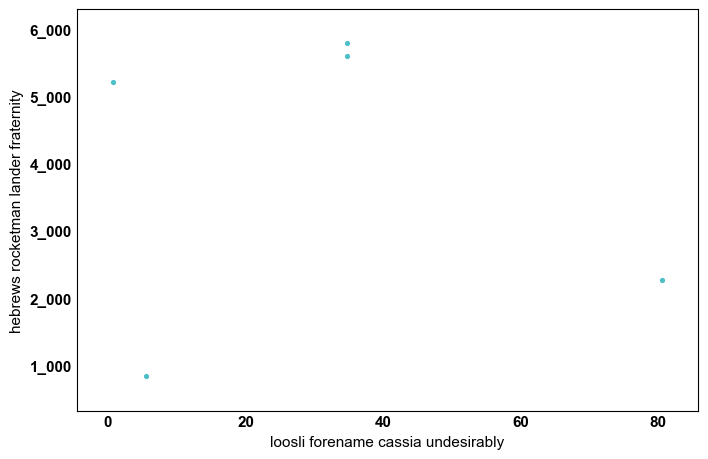

  0%|          | 1/50000 [00:00<2:39:54,  5.21it/s]

[6698, 6707, 6716, 6725, 6734, 6743, 6752, 6761, 6770, 6779, 6788, 6797, 6806, 6815, 6824, 6833, 6842, 6851, 6860, 6869] [18, 918, 16, 3, 15, 50, 5, 12, 658, 105, 526, 27, 1007, 526, 955, 1052, 7, 526, 433, 13]


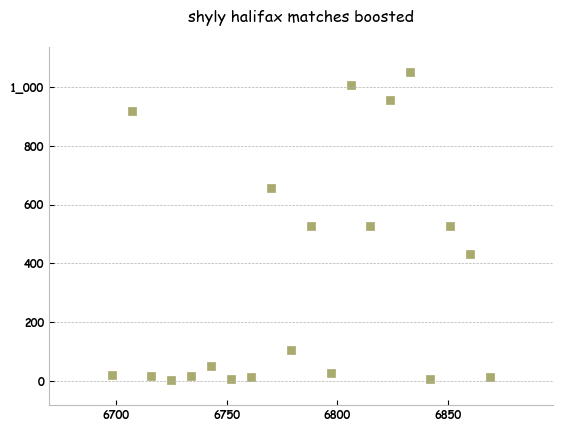

  0%|          | 2/50000 [00:00<2:06:50,  6.57it/s]

[5.32, 5.36, 6.5, 6.61, 10.58, 11.54, 18.54, 31.35, 31.74, 32.32, 33.45] [16, 5, 12, 4, 3, 3, 3, 4, 3, 4, 3]


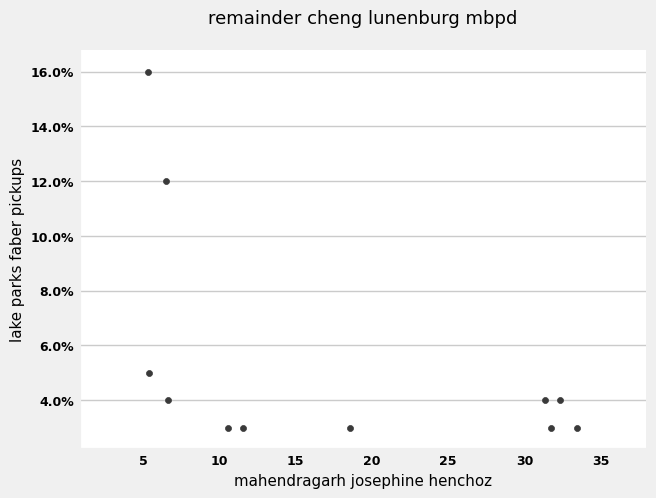

  0%|          | 3/50000 [00:00<2:41:06,  5.17it/s]

[6709, 6959, 7209, 7459, 7709, 7959, 8209] [5956.27, 5396.75, 7894.79, 504.07, 899.52, 500.06, 727.22]


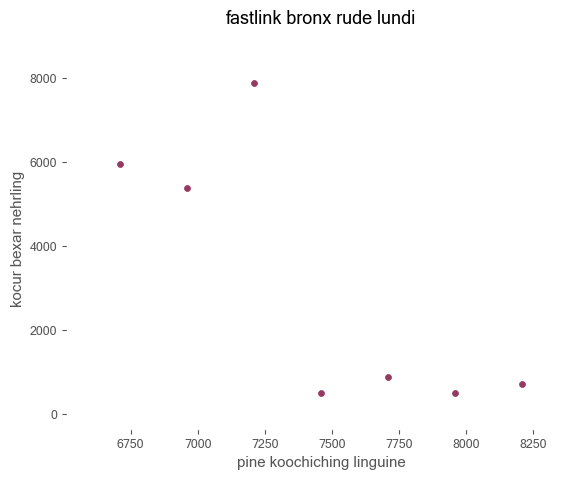

  0%|          | 4/50000 [00:00<2:25:20,  5.73it/s]

[0.88, 1.15, 1.75, 2.12, 3.06, 3.35, 4.46, 5.58, 6.12, 6.72, 6.99, 8.73, 9.04, 9.75, 11.48, 12.7, 13.39, 14.97, 15.39, 16.19, 19.11, 20.67, 30.02, 30.26, 35.48, 37.03, 38.17] [34, 23, 54, 41, 24, 22, 37, 62, 22, 35, 17, 10, 13, 61, 36, 24, 9, 41, 44, 9, 10, 33, 56, 9, 22, 11, 27]


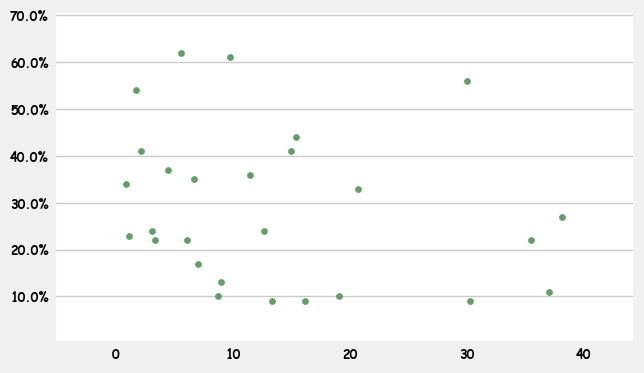

  0%|          | 5/50000 [00:00<2:07:22,  6.54it/s]

[143.98, 173.2, 178.65, 338.73, 479.25] [19.38, 9.93, 35.39, 27.92, 9.31]


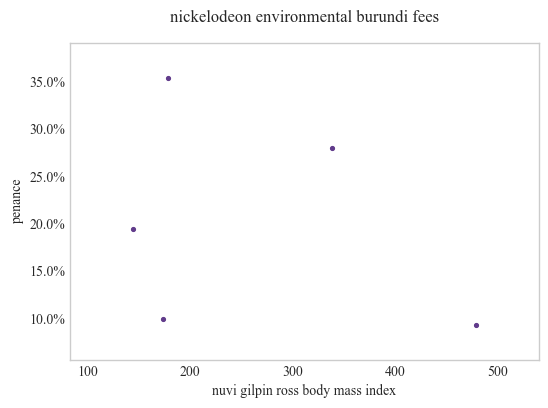

  0%|          | 6/50000 [00:01<2:18:42,  6.01it/s]

[10.15, 10.55, 11.36, 11.74, 12.12, 14.98, 23.63] [55.81, 3.5, 3.34, 69.32, 3.36, 11.88, 66.09]


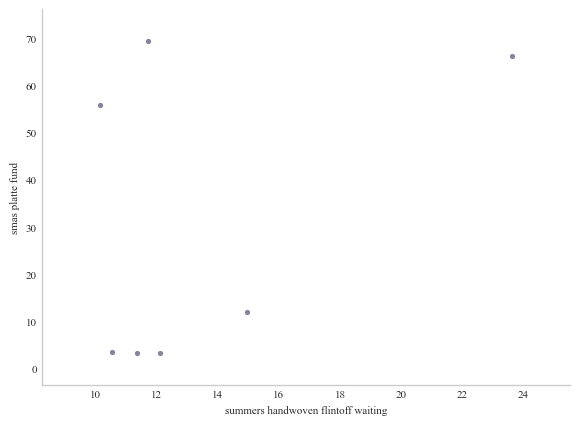

  0%|          | 7/50000 [00:01<2:22:11,  5.86it/s]

[1713.79, 1715.04, 1715.54, 1738.54, 1743.48, 1777.97, 1785.53, 1794.41, 2040.76, 2084.21, 2154.04, 2564.05, 2666.71, 2777.02, 4050.37, 4153.6, 4416.28, 4710.68, 5961.93, 6184.48, 6533.95, 6835.82, 9535.44, 9574.4, 9911.32] [12, 8, 4, 10, 11, 15, 2, 9, 17, 14, 13, 17, 19, 2, 1, 10, 7, 1, 8, 12, 1, 15, 11, 12, 6]


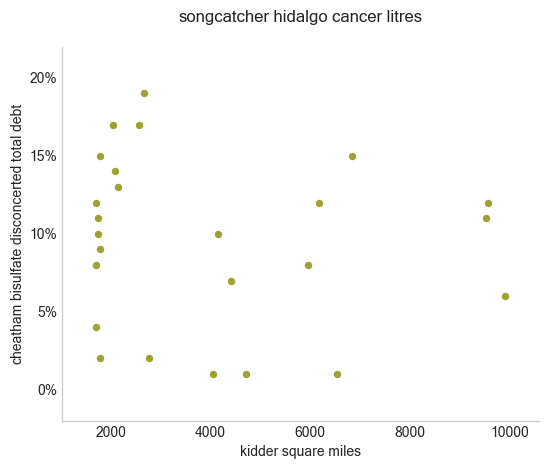

  0%|          | 8/50000 [00:01<2:23:06,  5.82it/s]

[2603, 2604, 2605, 2606, 2607] [34, 7, 24, 31, 6]


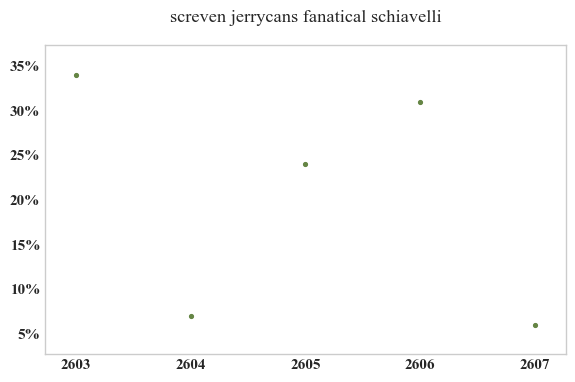

  0%|          | 9/50000 [00:01<2:11:21,  6.34it/s]

[180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212] [7, 8, 11, 9, 9, 8, 16, 9, 19, 16, 9, 43, 7, 7, 21, 9, 45]


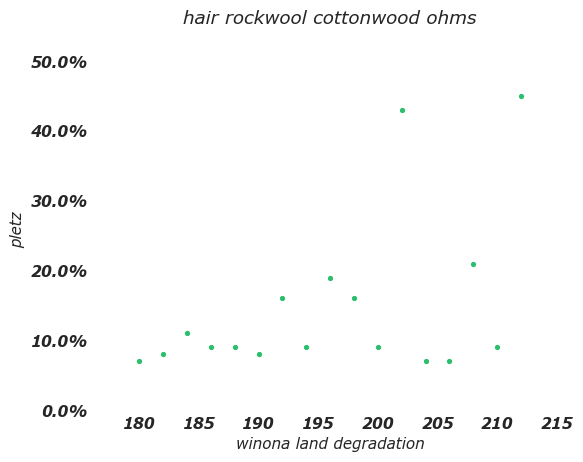

  2%|▏         | 981/50000 [01:26<1:12:49, 11.22it/s]/var/folders/s8/kn1s0g_s407d23sqsmvzcql80000gn/T/ipykernel_41052/1062201075.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return math.sqrt(((x2 - x1)/xrange) ** 2 + ((y2 - y1)/yrange) ** 2)
  5%|▌         | 2542/50000 [03:55<1:07:47, 11.67it/s]/var/folders/s8/kn1s0g_s407d23sqsmvzcql80000gn/T/ipykernel_41052/1062201075.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return math.sqrt(((x2 - x1)/xrange) ** 2 + ((y2 - y1)/yrange) ** 2)
  6%|▌         | 3092/50000 [04:43<1:02:03, 12.60it/s]/var/folders/s8/kn1s0g_s407d23sqsmvzcql80000gn/T/ipykernel_41052/1062201075.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return math.sqrt(((x2 - x1)/xrange) ** 2 + ((y2 - y1)/yrange) ** 2)
  7%|▋         | 3323/50000 [05:04<59:37, 13.05it/s]  /var/folders/s8/kn1s0g_s407d23sqsmvzcql80000gn/T/ipykernel_41052/1062201075.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return ma

In [30]:
# Seed for reproducability
np.random.seed(SEED)

import os
os.makedirs(f'{config.out_file}images', exist_ok=True)
os.makedirs(f'{config.out_file}annotations', exist_ok=True)

meta_data = generation_helper(chart_type, n=GENERATE_N_IMAGES, all_charts=ALL_TYPES)

In [ ]:
# pd.read_csv('/kaggle/working/metadata.csv')